In [1]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
    width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
   width:max-content;
}
</style>

In [ ]:
#import dask.array as da
#import dask.dataframe as dd

In [2]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.types import StringType, DateType
from pyspark.sql.functions import lit, year, month, dayofmonth, last_day, col, array, explode, struct, udf, to_date, month, year, percent_rank, when, lag, first, avg
from pyspark.sql.functions import sum as spark_sum, max as spark_max, min as spark_min

In [3]:
import OpSpark

In [4]:
spark = SparkSession.builder.appName('Rank_Median').getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Rank_Median>

In [ ]:
#dd.read_parquet("data/master/ophelia/data/OpheliaData/analytical_base_table")

In [5]:
## por temas de replicación, siempre es mejor convertir el archivo a leer en formato csv

monthly_data_df = spark.read.parquet("data/master/ophelia/data/OpheliaData/analytical_base_table")
index_vector_csv = spark.read.csv("data/raw/csv/unique_dateprice_vector.csv", header=True, inferSchema=True)

In [6]:
from datetime import datetime

def datetime_object(datetime_str):
    datetime_object = datetime.strptime(datetime_str, '%d/%m/%y').date()
    return datetime_object

datetime_object_udf = udf(f=datetime_object, returnType=DateType())

In [7]:
index_vector_schema = index_vector_csv.select("MXWDU_Index", datetime_object_udf(col("operation_date")).alias('operation_date'))
index_vector_schema.show(10, False)

+-----------+--------------+
|MXWDU_Index|operation_date|
+-----------+--------------+
|51.12      |2016-01-01    |
|54.830002  |2016-01-04    |
|54.880001  |2016-01-05    |
|54.049999  |2016-01-06    |
|52.790001  |2016-01-07    |
|52.18      |2016-01-08    |
|52.240002  |2016-01-11    |
|52.580002  |2016-01-12    |
|51.509998  |2016-01-13    |
|52.259998  |2016-01-14    |
+-----------+--------------+
only showing top 10 rows



In [8]:
close_date_index = index_vector_schema.select("*", month(col("operation_date")).alias("month"), year(col("operation_date")).alias("year"))\
                                      .groupBy("year", "month").agg(spark_max("operation_date").alias("operation_date")).drop("year", "month")\
                                      .join(index_vector_schema, on="operation_date", how="left")
print(close_date_index.shape)
close_date_index.orderBy(col("operation_date").desc()).show(10, False)

(44, 2)
+--------------+-----------+
|operation_date|MXWDU_Index|
+--------------+-----------+
|2019-08-15    |70.279999  |
|2019-07-31    |73.760002  |
|2019-06-28    |73.709999  |
|2019-05-31    |70.089996  |
|2019-04-30    |74.620003  |
|2019-03-29    |72.150002  |
|2019-02-28    |71.029999  |
|2019-01-31    |69.32      |
|2018-12-31    |64.160004  |
|2018-11-30    |69.830002  |
+--------------+-----------+
only showing top 10 rows



In [9]:
index_portfolio_df = close_date_index.join(monthly_data_df, on="operation_date", how="left")
print(index_portfolio_df.shape)
index_portfolio_df.orderBy(col("operation_date")).show(10, False)

(44, 214)
+--------------+-----------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+--------+--------+--------+---------+--------+--------+--------+--------+--------+---------+--------+--------+---------+--------+--------+--------+--------+---------+--------+---------+---------+--------+---------+--------+--------+--------+--------+-------+--------+---------+--------+---------+--------+----------+--------+----------+---------+--------+----------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+----------+----------+----------+----------+--------+----------+----------+----------+----------+---------+-------

In [10]:
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [11]:
def evolved_time_frame(df):
    table = df.toPandas()
    plt.figure(figsize=(20, 10))
    for c in table.columns.values:
        plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
    plt.ylabel('price in $')

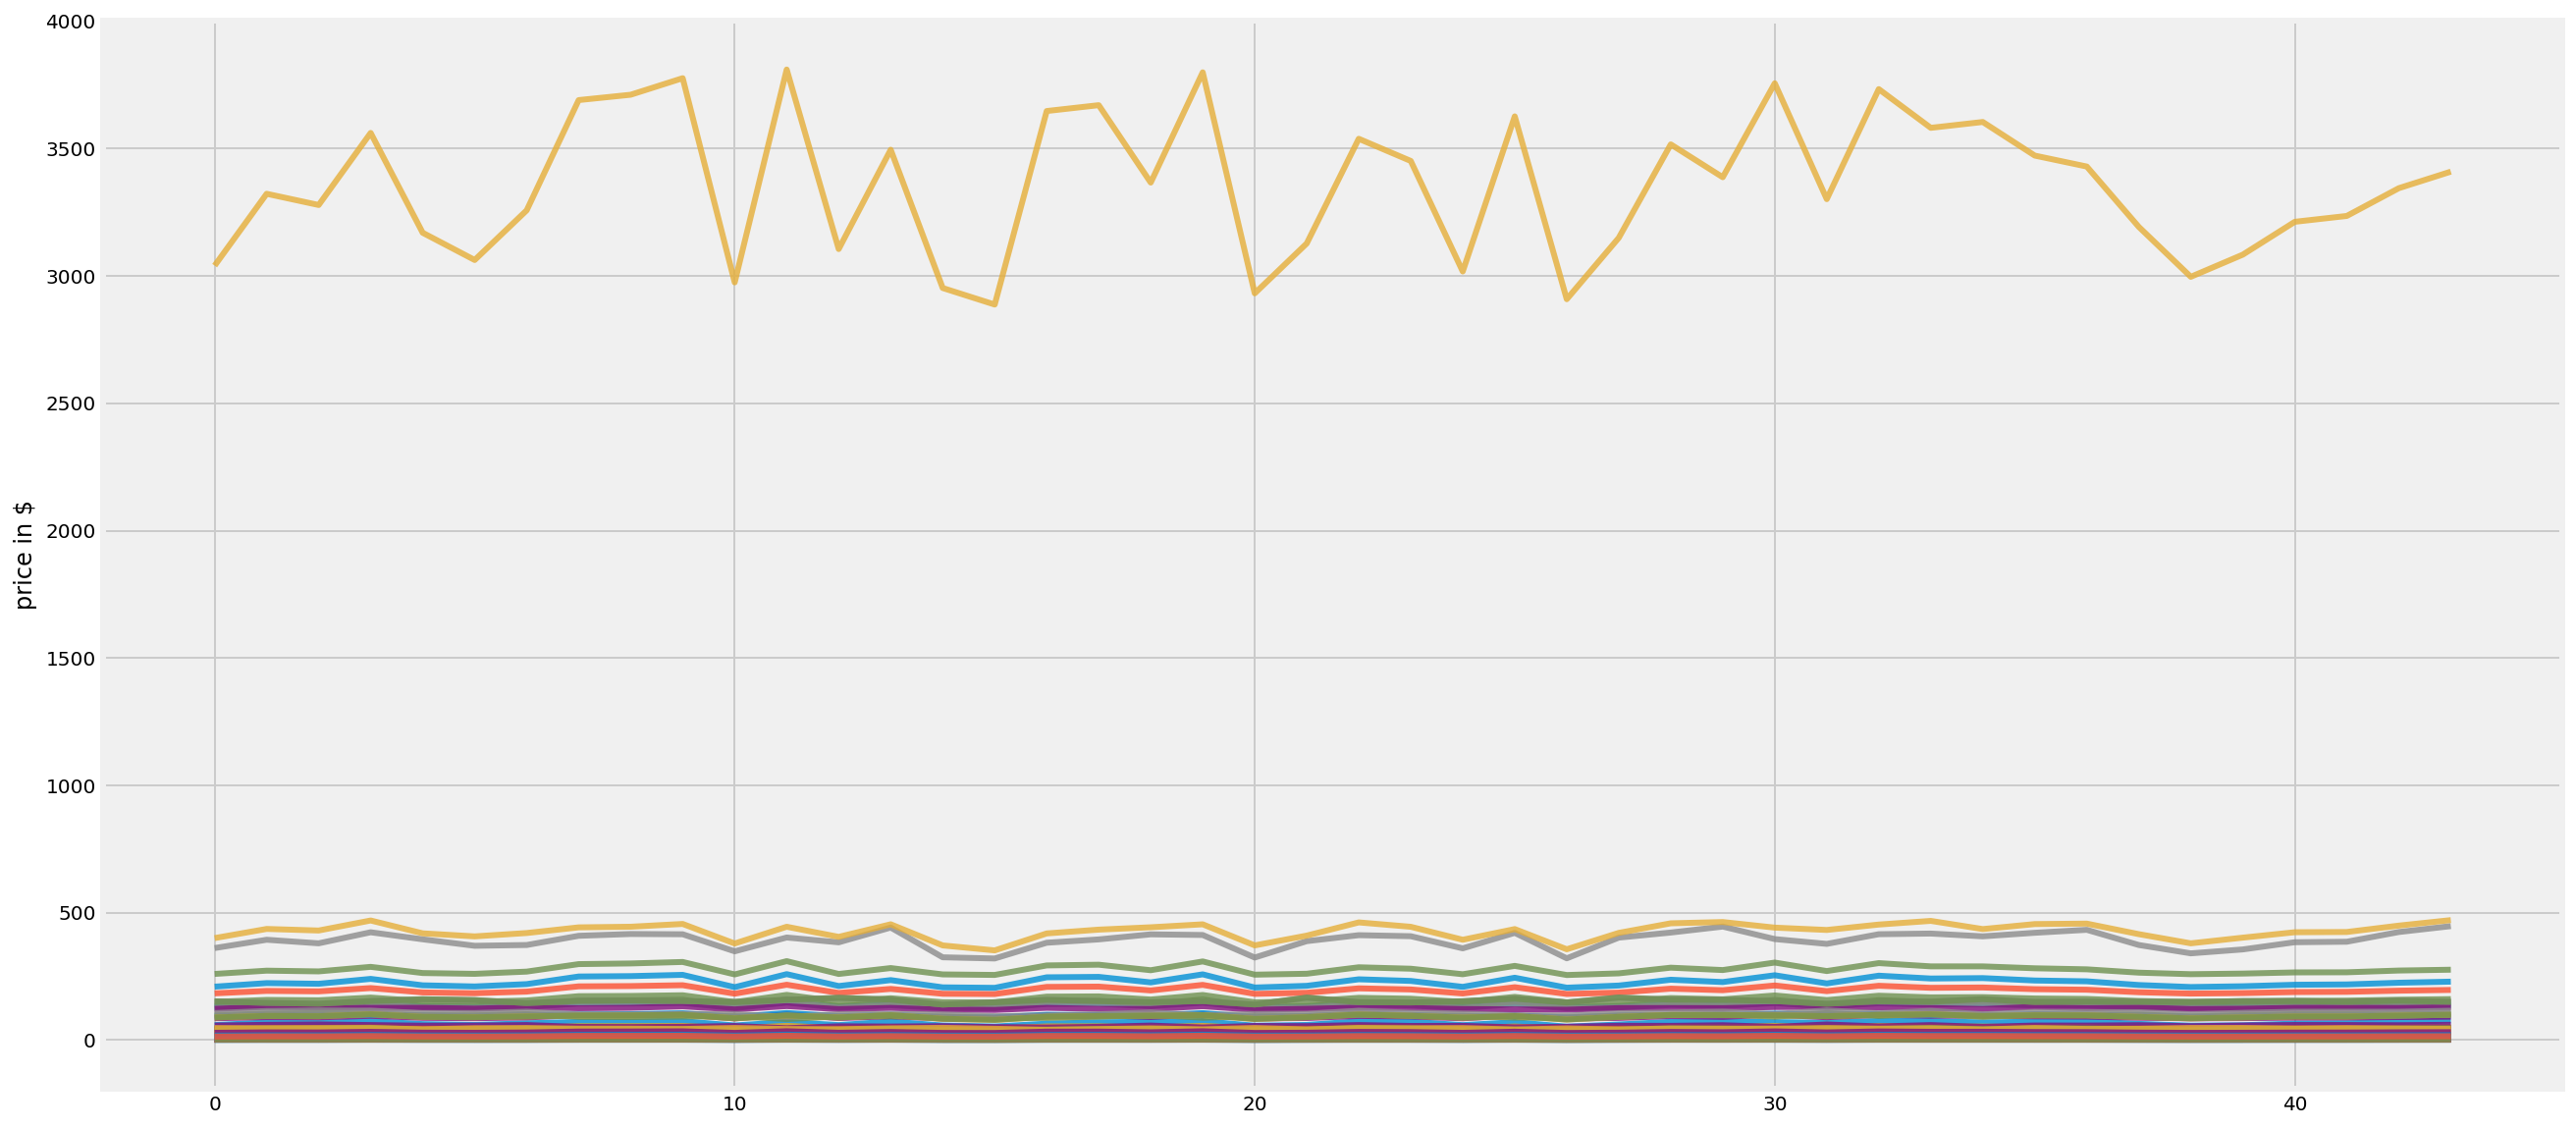

In [12]:
evolved_time_frame(index_portfolio_df.drop("operation_date"))

# me ahorro este paso, ya no es necesario pasarlo a pandas

In [ ]:
monthly_data = index_portfolio_df.toPandas()
print("nuestros datos:", monthly_data.shape)
monthly_data

In [ ]:
#test_pd = monthly_data.drop(['operation_date', 'operation_id'], axis=1).pct_change(1).fillna(0)

In [ ]:
#test_dask = dd.from_pandas(test_pd, npartitions=3)

In [ ]:
#test_dask.corr().compute()

In [ ]:
#dd.from_pandas((monthly_data.drop(['operation_date', 'operation_id'], axis=1)), npartitions=3).corr().compute()

In [13]:
# test

operate_cols = index_portfolio_df.remove_element(['operation_date', 'operation_id'])
pct_change_df = index_portfolio_df.pct_change(pct_cols=operate_cols, order_by="operation_date").na.fill(np.nan)#.dropna(thresh=4)
print(pct_change_df.shape)
pct_change_df.show(5, False)

(44, 212)
+---------------------+----------------------+----------------------+----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+----------------------+---------------------+---------------------+----------------------+----------------------+----------------------+---------

In [22]:
import dask.dataframe as dd
import dask.array as da

#from pyspark.sql import DataFrame

In [ ]:
#dd.read_parquet('data/master/ophelia/data/OpheliaData/analytical_base_table').to_dask_array().compute()

In [ ]:
#import os

In [ ]:
#def __spark_to_dask(self):
#    tmp_path = os.getcwd() + '/data/tmp/'
#    self.coalesce(1).write.mode('overwrite').parquet(tmp_path)
#    return dd.read_parquet(tmp_path)

#def add_to_series():
#    def spark_to_series(self, column_series):
#        dask_df = __spark_to_dask(self)
#        series = dask_df[column_series]
#        list_dask = series.to_delayed()
#        full = [da.from_delayed(i, i.compute().shape, i.compute().dtype) for i in list_dask]
#        return da.concatenate(full)
#    DataFrame.toPandasSeries = spark_to_series
#    
#def add_to_numpy():
#    def spark_to_numpy(self, column_series):
#        add_to_series()
#        dask_array = self.toPandasSeries(column_series)
#        return da.from_array(dask_array.compute())
#    DataFrame.toNumpyArray = spark_to_numpy

In [ ]:
#add_to_series()
#add_to_numpy()

In [ ]:
pct_benchmark_month.toPandasSeries('MXWDU_Index').compute()

In [ ]:
pct_benchmark_month.toNumpyArray('MXWDU_Index').compute()

In [ ]:
## seleccionamos la primera colu.ipynb_checkpoints/na y lo convertimos a vector, esta columna representa el indice que estamos analizando, 
## 'MXWDU_Index', la idea es medir esta columna con el resto, ya que las demás son acciones que forman parte de ése índice.

#benchmark_month = monthly_data["MXWDU_Index"]

# nuestros datos
#print(benchmark_month.shape)
#benchmark_month

In [ ]:
## Calculamos el porcentaje de cambio de un día contra otro.
## fórmula: (t+1 / t)-1
## pseudo-código: (precio_hoy / precio_ayer)-1

#pct_benchmark_month = benchmark_month.pct_change(1)
#pct_benchmark_month

# nuestros datos

In [ ]:
## el vector de "percentage change" se convierte a un arreglo numpy de dimensión (147,)
## NOTA: en los arreglos (objetos) de tipo numpy.array preservan los valores, tanto por fila, como por columna,
##       el órden de los elementos, cómo un 'índice implícito'

#pct_benchmark_month_array = np.array(pct_benchmark_month)
#print(pct_benchmark_month_array.shape)
#print(pct_benchmark_month_array)

In [14]:
pct_benchmark_month = pct_change_df.select('MXWDU_Index')
print(pct_benchmark_month.shape)
pct_benchmark_month.show(5, False)

(44,)
+---------------------+
|MXWDU_Index          |
+---------------------+
|NaN                  |
|0.04951626422191602  |
|-6.779148406206303E-4|
|-0.04911142381103539 |
|0.06463129203203266  |
+---------------------+
only showing top 5 rows



In [15]:
## el vector de "percentage change" se convierte a un arreglo numpy de dimensión (147,)
## NOTA: en los arreglos (objetos) de tipo numpy.array preservan los valores, tanto por fila, como por columna,
##       el órden de los elementos, cómo un 'índice implícito'

pct_benchmark_month_array = pct_benchmark_month.toNumpyArray('MXWDU_Index')
print(pct_benchmark_month_array.shape)
pct_benchmark_month_array.compute()

(44,)


array([        nan,  0.04951626, -0.00067791, -0.04911142,  0.06463129,
       -0.03310106, -0.01552326, -0.02407432, -0.07443733,  0.08837278,
       -0.01560939,  0.08030265, -0.00605984, -0.00690957, -0.02974079,
        0.01701348, -0.00470073, -0.00402835,  0.01520229,  0.04684704,
       -0.05393702, -0.0051324 , -0.01979919, -0.02105267, -0.01845389,
       -0.0039971 , -0.02660525,  0.00320658, -0.02161336, -0.01586809,
       -0.01327853, -0.02451136, -0.02824768, -0.01014024, -0.01024414,
        0.01949279, -0.00930624, -0.0034159 , -0.03633244,  0.01369376,
       -0.00333332, -0.0132019 , -0.0688548 ,  0.01264368])

In [ ]:
## Lo mismo hacemos, pero para el resto de variables equity,
## seleccionamos la primera columna y lo convertimos a vector, esta columna representa el indice que estamos analizando, 
## 'MXWDU_Index', la idea es medir esta columna con el resto, ya que las demás son acciones que forman parte de ese índice.

#investment_universe_month = monthly_data.drop(['operation_id', "operation_date", "MXWDU_Index"], axis = 1)

In [ ]:
## (t+1 / t)-1
## (precio_hoy / precio_ayer)-1

#pct_investment_month = investment_universe_month.pct_change(1)

In [ ]:
## el vector de percentage change se convierte a un arreglo numpy de dimensión (147,70)

#pct_investment_month_array = np.array(pct_investment_month)
##_pct_investment_month_array = np.array(_pct_investment_month)
#
## nuestros datos
#print(pct_investment_month_array.shape)
#print(pct_investment_month_array)

In [16]:
pct_investment_month = pct_change_df.drop('MXWDU_Index')
print(pct_investment_month.shape)
pct_investment_month.show(5, False)

(44, 211)
+----------------------+----------------------+----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+----------------------+----------------------+----------------------+----------------------+----------------------+---------------------+----------------------+---------------------+---------------------+----------------------+----------------------+----------------------+---------------------+---------

In [17]:
## el vector de percentage change se convierte a un arreglo numpy de dimensión (147,70)

#pct_investment_month_array = np.array(pct_investment_month)
#_pct_investment_month_array = np.array(_pct_investment_month)

pct_investment_month_array = pct_investment_month.toNumpyArray()
# nuestros datos
print(pct_investment_month_array.compute().shape)
print(pct_investment_month_array.compute())

(44, 211)
[[        nan         nan         nan ...         nan         nan
          nan]
 [-0.00300141 -0.00221145 -0.00318045 ... -0.0051317  -0.00505864
  -0.00368432]
 [-0.00655662 -0.00485491 -0.00698418 ... -0.00736942 -0.00674264
  -0.00641409]
 ...
 [-0.00280483 -0.00140868 -0.0027296  ... -0.00278404 -0.00289304
  -0.00270924]
 [-0.0029431  -0.00140606 -0.00295482 ... -0.00340346 -0.00445736
  -0.00338504]
 [-0.00279266 -0.00084889 -0.00244511 ... -0.00155385 -0.00114779
  -0.00238187]]


In [18]:
## creamos arreglos numpy con dimensiones X+1 = 148, rellenas de ceros, para ser imputados con nuevos vectores

up_month = np.zeros((pct_benchmark_month_array.shape[0]+1, 1))
down_month = np.zeros((pct_benchmark_month_array.shape[0]+1, 1))
up_move = np.zeros((pct_benchmark_month_array.shape[0]+1, pct_investment_month_array.shape[1]))
down_move = np.zeros((pct_benchmark_month_array.shape[0]+1, pct_investment_month_array.shape[1]))

print(up_month.shape)
print(down_month.shape)
print(up_move.shape)
print(down_move.shape)

(45, 1)
(45, 1)
(45, 211)
(45, 211)


In [19]:
## rellenamos las matrices de ceros con valores que aprueben las condiciones, 
## se realiza una comparación dentro de los arreglos de porcentajes de cambio, 
## sí alguno de esos porcentajes es superior a 0, entonces entra a los arreglos 
## de movimientos positivos (incrementos), pero sí alguno es menor que 0, entonces
## el porcentaje se almacena en los arreglos de movimientos negativos (decrementos).

## Básicamente, se separan los porcentajes de cambio en dos matrices: 
## matriz de positivos cuando el porcentaje es > 0 
## matriz de negativos cuando el porcentaje es <= 0

size_benchmark_matrix = pct_benchmark_month_array.shape[0]
for i in range (1, size_benchmark_matrix):
    if pct_benchmark_month_array.compute()[i] > 0:
        up_month[i] = pct_benchmark_month_array.compute()[i]
        up_move[i] = pct_investment_month_array.compute()[i, 0:pct_investment_month_array.shape[1]]
    else:
        down_month[i] = pct_benchmark_month_array.compute()[i]
        down_move[i] = pct_investment_month_array.compute()[i, 0:pct_investment_month_array.shape[1]]

In [20]:
print(up_month.shape)
print(down_month.shape)
print(up_move.shape)
print(down_move.shape)

(45, 1)
(45, 1)
(45, 211)
(45, 211)


In [23]:
up_month_dask = da.from_array(up_month)
up_move_dask = da.from_array(up_move)
down_month_dask = da.from_array(down_month)
down_move_dask = da.from_array(down_move)

In [ ]:
## calculamos los vectores 'peor más alto' y 'mejor más alto'

#np.seterr(divide='ignore', invalid='ignore')
#greater_worse = down_move / down_month
#greater_better = (up_move / up_month) * float(-1.0)
#
#print(greater_worse.shape)
#print(greater_better.shape)

In [24]:
## calculamos los vectores 'peor más alto' y 'mejor más alto'

#np.seterr(divide='ignore', invalid='ignore')
greater_worse = down_move_dask / down_month_dask
greater_better = (up_move_dask / up_month_dask) * float(-1.0)

print(greater_worse.shape)
print(greater_better.shape)

(45, 211)
(45, 211)


In [30]:
greater_worse.compute()

/Users/falva/opt/anaconda3/envs/ophelia/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 9.67174414,  7.16153682, 10.30243998, ..., 10.87071798,
         9.94615004,  9.46149696],
       ...,
       [ 0.0427435 ,  0.02042071,  0.04291383, ...,  0.04942951,
         0.06473571,  0.04916203],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [ ]:
#ddf = dd.concat([dd.from_dask_array(c) for c in [c1,c2,c3]], axis = 1)

In [ ]:
#import h5py
#f = h5py.File('myfile.hdf5', 'a')
#d = f.require_dataset('/data', shape=up_month_dask.shape, dtype=up_month_dask.dtype)
#da.store(up_month_dask, d)

In [25]:
## ambos vectores los convertimos a pandas dataframes, y solo nos quedamos con los vectores que tengan valores != np.nan
## una de las ventajas de los pandas dataframes es que mantienen un ídince único por row, esto lo hace poder separarse, y juntarse
## en cuantos sub-conjuntos se requieran y siempre se podrá mantener un órden.

greater_worse_df = greater_worse.to_dask_dataframe().dropna().compute()
greater_better_df = greater_better.to_dask_dataframe().dropna().compute()

print(greater_worse_df.shape)
print(greater_better_df.shape)

(32, 211)
(11, 211)


/Users/falva/opt/anaconda3/envs/ophelia/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/falva/opt/anaconda3/envs/ophelia/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [ ]:
def mask(df, f):
    return df[f(df)]

In [ ]:
#greater_better_df.mask(lambda x: x[0] < 0)

In [ ]:
greater_worse_df

In [28]:
## ambos vectores los convertimos a pandas dataframes, y solo nos quedamos con los vectores que tengan valores != np.nan
## una de las ventajas de los pandas dataframes es que mantienen un ídince único por row, esto lo hace poder separarse, y juntarse
## en cuantos sub-conjuntos se requieran y siempre se podrá mantener un órden.

#greater_worse_df = dd.from_pandas(data=greater_worse).dropna()
#greater_better_df = dd.from_pandas(data=greater_better).dropna()
#
#print(greater_worse_df.shape)
#print(greater_better_df.shape)

In [27]:
## calculamos ahora, la mediana acumulada con los pandas dataframes que construimos, 
## con un periodo mínimo (método expanding) de al menos 1 observación dada.

median_down = greater_worse_df.expanding().median()
median_up = greater_better_df.expanding().median()

print(median_down.shape)
print(median_up.shape)

(32, 211)
(11, 211)


In [ ]:
#greater_worse_df.expanding().cov()

In [ ]:
# se transponen ambos pandas df por la columna periodos, columna que almacena números no consecutivos desde 1 hasta 147

down_transpose = median_down.T
up_transpose = median_up.T

print(down_transpose.shape)
print(up_transpose.shape)

In [ ]:
# se rankean los resultados (top 10) entre las fechas cierre (periodo) y se vuelve a transponer la tabla ranked_down

ranked_down = down_transpose.rank(method='first')
transpose_ranked_down = ranked_down.T

print(ranked_down.shape)
print(transpose_ranked_down.shape)

In [ ]:
# se rankean los resultados (top 10) entre las fechas cierre (periodo) y se vuelve a transponer la tabla ranked_up

ranked_up = up_transpose.rank(method='first')
transpose_ranked_up = ranked_up.T

print(ranked_up.shape)
print(transpose_ranked_up.shape)

In [ ]:
transpose_ranked_up

In [ ]:
## se añade variable 'label' con la idea de que al juntar ambos dataframes se puedan distinguir los 'worse' de los 'better'
## y se unen ambos dataframes con la etiqueta creada, se usó el método 'insert' por lo que no se deberá correr de nuevo, una
## vez ejecutado ya que fallará por duplicidad de columnas.

worse_better_pd = pd.concat([transpose_ranked_up, transpose_ranked_down]).sort_index()
print(worse_better_pd.shape)
worse_better_pd

In [ ]:
## se crea un índice 'closing_id' para cada registro, éste corre de [1:N+1] 
## con la idea de etiquetar el id del mes de registro de cierre,
## de la misma forma que lo anterior, NO se deberá ejecutar de nuevo; una vez hecho.

worse_better_pd['closing_id'] = range(1, len(worse_better_pd) + 1)
print(worse_better_pd.shape)
worse_better_pd

In [ ]:
## se transponen ambos dataframes, de antes tener una dimensión (68, 70), es decir; 
## 68 registros i.e. 'Rows' (variables)
## 70 columnas fijas (a menos que sea añadido otro asset desde el csv inicial)

## a tener una dimensión 'transpuesta' (invertída sí querés...) de (70, 68), es decir;
## 70 registros i.e. 'Rows' fijos (a menos que sea añadido otro asset desde el csv inicial)
## 68 columnas (variables)

In [ ]:
asset_name_list = index_portfolio_df.drop('operation_id', "operation_date", "MXWDU_Index").columns
print(asset_name_list, '\n')

In [ ]:
## de pandas dataframes, una vez separados en dos conjuntos ['worse', 'better'],
## creamos por separado dos spark dataframes.

worse_better_df = spark.createDataFrame(worse_better_pd)
worse_better_df.show(5, False)

In [ ]:
mapping = dict(zip((worse_better_df.columns), asset_name_list))
mapped_name_df = worse_better_df.select([col(c).alias(mapping.get(c, c)) for c in worse_better_df.columns])
print(mapped_name_df.shape)
mapped_name_df.show(5, False)

In [ ]:
#mapped_name_df.coalesce(1).write.mode("overwrite").parquet("data/ophelia/out/engine/RankMedian")

# Finish Rank Median Module

# Start TopAssetRank

In [ ]:
worse_better = spark.read.parquet("data/ophelia/out/engine/RankMedian/")

In [ ]:
## se crea un generador "shape long format", una lista con iteraciones, esta lista trabajará con dos variables principales,
## 1-. la variable 'equity_index', será la que contenga los 'id' de los activos
## 2-. la variable 'median_down', será la que contenga la mediana acumulada por cada activo.
## Se mantendrá a lo largo de la transformación 1 columna fija; 'closing_id',
## closing_id: variable que indica el mes de cierre y reporte de precio

def panel_format(df, pivot_col, new_columns: list = []):
    first_col = str(new_columns[0])
    second_col = str(new_columns[1])
    piv_col = [pivot_col]
    df_types = df.dtypes
    cols, dtype = zip(*[(c, t) for (c, t) in df_types if c not in piv_col])
    if len(set(dtype)) > 1:
        raise ValueError("Columns not the same data type...")
    generator_explode = explode(array([
        struct(lit(c).alias(first_col), col(c).alias(second_col)) for c in cols
    ])).alias("column_explode")
    column_to_explode = ["column_explode."+first_col, "column_explode."+second_col]
    panel_df = df.select(piv_col + [generator_explode])\
                 .select(piv_col + column_to_explode)
    return panel_df

In [ ]:
worse_better.show(5, False)

In [ ]:
## se crea nuevo spark-dataframe donde solo se mostrará por partición ['closing_id'] 
## el top 10 mejores meses donde tuvo menos malos que el resto de los registros; ["top_rank"].
new_columns = ["ticker", "rank"]
asset_ranking_df = worse_better.transpose("closing_id", new_columns)
print(asset_ranking_df.shape)
asset_ranking_df.printSchema()
asset_ranking_df.show(10, False)

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
map_asset_id = dict(zip(asset_name_list, worse_better_df.columns))

In [ ]:
from pyspark.sql.functions import col, create_map, lit
from itertools import chain

mapping_expr = create_map([lit(x) for x in chain(*map_asset_id.items())])

In [ ]:
asset_rank_10 = asset_ranking_df.where(col("rank") <= 10).select('*', mapping_expr.getItem(col('ticker')).alias('ticker_id')).orderBy("closing_id", "rank")
asset_rank_10.coalesce(1).write.mode("overwrite").parquet("data/ophelia/out/engine/LongMedianRank")

In [ ]:
asset_rank_10.show(5, False)

# Finish TopAssetRank

# Start TrainPortfolioSimulation

In [ ]:
asset_rank_10_pd = pd.read_parquet("data/ophelia/out/engine/LongMedianRank/")
asset_rank_10_pd

In [ ]:
# buscar el asset_id de la matriz

In [ ]:
pandas_df = asset_rank_10_pd.astype({'ticker_id':'int32'}) # le damos el tipo de dato int32 a la columna ticker
newselect = asset_rank_10_pd[["closing_id", "ticker_id"]] # seleccionamos solo estas dos columnas
num_of_assets = 10 # numero de assets que se crearan

indexed = np.zeros((investment_universe_month.shape[0], num_of_assets))

for q in range(1,investment_universe_month.shape[0]):
    selection = newselect.loc[pandas_df["closing_id"]==q]
    newselect_transpose = selection.T
    newpdf = newselect_transpose['ticker_id':].head()
    indexed[q] = newpdf

In [ ]:
## lo que se pretende ahora, es obtener una matriz de dimensión (146, 10), es decir, 
## tener en cada row las fechas de cierre [closing_id],
## en cada columna (header) el número de ranking top 10 [top_rank],
## y en cada campo, el id del activo [asset_id].

pandas_df = asset_rank_10_pd.astype({'ticker_id':'int32'}) # le damos el tipo de dato int32 a la columna ticker
newselect = asset_rank_10_pd[["closing_id", "ticker_id"]] # seleccionamos solo estas dos columnas
num_of_assets = 10 # numero de assets que se crearan
investment_universe_month = index_portfolio_df.drop('operation_id', "operation_date", "MXWDU_Index")
indexed = np.zeros((investment_universe_month.shape[0], num_of_assets))

for q in range(1,investment_universe_month.shape[0]):
    selection = newselect.loc[pandas_df["closing_id"]==q]
    newselect_transpose = selection.T
    newpdf = newselect_transpose['ticker_id':].head()
    indexed[q] = newpdf

In [ ]:
pct_investment_month_array.compute().shape

In [ ]:
index_row.shape

In [ ]:
investment_universe_month.shape

In [ ]:
indexed.shape

In [ ]:
indexed = indexed[1:investment_universe_month.shape[0]+1]
index_row = indexed.astype(np.int64)
newrow = [0]*num_of_assets #np.zeros((1,num_of_assets))
index_row = np.vstack([index_row, newrow])
portfolio = np.zeros((investment_universe_month.shape[0], num_of_assets))

for r in range(0, investment_universe_month.shape[0]-1):
    s = r+1
    print(s)
    columns = index_row[s]
    print(columns)
    portfolio[s] = pct_investment_month_array.compute()[s,[columns]]

In [ ]:
means = portfolio[1:investment_universe_month.shape[0]-1]
performance = np.dot(portfolio,(1/num_of_assets))
returns = np.zeros((investment_universe_month.shape[0]-1,1))
equalw = np.zeros((investment_universe_month.shape[0]-1,1))
eweights = 1/(pct_investment_month_array.shape[1])
eweighted = np.dot(pct_investment_month_array,eweights)

for x in range (1,investment_universe_month.shape[0]):
    returns[x-1] = sum(performance[x])
    equalw[x-1] = sum(eweighted[x])

In [ ]:
beg = 100
start = 100
commence = 100
bench = pct_benchmark_month_array[1:investment_universe_month.shape[0]]
bmk = np.zeros((investment_universe_month.shape[0],))
port = np.zeros((investment_universe_month.shape[0]-1,))
ew = np.zeros((investment_universe_month.shape[0]-1,))

for i in range (0,investment_universe_month.shape[0]-1):
    bmk[i] = beg*(1+bench[i])
    beg = bmk[i]
    port[i] = start*(1+returns[i])
    start = port[i]
    ew[i] = commence*(1+equalw[i])
    commence = ew[i]

plt.plot(bmk[0:investment_universe_month.shape[0]-1])
plt.plot(port)
plt.plot(ew)

In [ ]:
index_row[index_row.shape[0]-2]

In [ ]:
input_assets = index_row[index_row.shape[0]-2]
input_assets1 = pct_investment_month_array[:, input_assets]
dataframe = pd.DataFrame(input_assets1)
input_assets1 = dataframe.dropna()
mean_returns = input_assets1.mean()
covar_matrix = input_assets1.cov()
tickers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 12
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(12)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

In [ ]:
def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio

        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]

    results_df = pd.DataFrame(results_matrix.T, columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])

    return results_df

In [ ]:
# TODO: revisar la sobrecarga de memoria en los stages marcados

mean_returns = input_assets1.mean()
cov = input_assets1.cov()
num_portfolios = 210000
rf = 0.0

results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]

min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

max_return_port = results_frame.iloc[results_frame['ret'].idxmax()]

plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev, results_frame.ret, c=results_frame.sharpe, cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
plt.scatter(max_sharpe_port['stdev'], max_sharpe_port['ret'], marker=(5,1,0), color='r', s=500)
plt.scatter(min_vol_port['stdev'], min_vol_port['ret'], marker=(5,1,0), color='g', s=500)
plt.scatter(max_return_port['stdev'], max_return_port['ret'], marker=(5,1,0), color='y', s=500)
plt.show()

In [ ]:
results_frame

In [ ]:
renamed_columns = {
    0: 'fund_w_zero',
    1: 'fund_w_one',
    2: 'fund_w_two',
    3: 'fund_w_three',
    4: 'fund_w_four',
    5: 'fund_w_five',
    6: 'fund_w_six',
    7: 'fund_w_seven',
    8: 'fund_w_eight',
    9: 'fund_w_nine'
}
results_frame_renamed = results_frame.rename(columns=renamed_columns)
results_frame_renamed.to_csv('data/ophelia/out/model/tmp/TrainSimulation.csv', encoding='utf-8', index=False)

In [ ]:
def pd_series_to_dict(pd_series):
    to_python_dict = dict(pd_series)
    return {str(k): float(v) for k, v in to_python_dict.items()}

In [ ]:
def key_map_rename(dic, new_key, old_key):
    for key in range(len(old_key)):
        dic[new_key[key]] = dic.pop(old_key[key])
    return dic

In [ ]:
def persist_metadata_model(dic_sample, json_name):
    dict_to_json = spark.read.json(sc.parallelize([dic_sample]))
    dict_to_json.coalesce(1).write.mode("overwrite").json("data/ophelia/out/model/model_info/"+str(json_name))

In [ ]:
max_return_port_sample = pd_series_to_dict(results_frame_renamed.iloc[results_frame_renamed['ret'].idxmax()])
persist_metadata_model(max_return_port_sample, "maxReturnTrainWeights")

In [ ]:
max_sharpe_port_sample = pd_series_to_dict(results_frame_renamed.iloc[results_frame_renamed['sharpe'].idxmax()])
persist_metadata_model(max_sharpe_port_sample, "maxSharpeTrainWeights")

In [ ]:
min_vol_port_sample = pd_series_to_dict(results_frame_renamed.iloc[results_frame_renamed['stdev'].idxmax()])
persist_metadata_model(min_vol_port_sample, "minVolatileTrainWeights")

# Finish TrainPortfolioSimulation

# Start EfficientFrontier

In [ ]:
import json

def json_read(json_path):
    with open(json_path) as json_file:
        return(json.load(json_file))

In [ ]:
json_p = 'data/ophelia/out/model/model_info/minVolatileTrainWeights/part-00000-7579777d-ef23-4098-9b2b-5c6a44cf1dfe-c000.json'
min_vol_port_sample = json_read(json_p)
min_vol_port_sample

In [ ]:
#json_p = 'data/ophelia/out/model/model_info/minVolatileTrainWeights/part-00000-6a7870c6-f591-4274-92c9-d1fa36fd0813-c000.json'
#min_vol_port_sample = json_read(json_p)
#min_vol_port_sample

In [ ]:
results_spark_df = spark.read.csv("data/ophelia/out/model/tmp/TrainSimulation.csv", header='true', inferSchema=True)
results_spark_df.show(5, False)
results_spark_df.describe().show(10, False)
results_spark_df.printSchema()

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id, current_date, current_timestamp
from pyspark.ml.feature import QuantileDiscretizer

results_index = results_spark_df.select("*", 
                                        (monotonically_increasing_id() + 1000).alias("portfolio_id"),
                                        current_date().alias("information_date"),
                                        current_timestamp().alias("model_date"))
results_index.show(5, False)

In [ ]:
# con x portafolios

filter_min_sharpe_df = results_index.where(col("sharpe") >= min_vol_port_sample['sharpe'])\
                                    .select("*", percent_rank().over(Window.orderBy(results_index['sharpe'])).alias("sharpe_centile"))
filter_min_sharpe_df.show(5, False)

# for quantile discretization we use two different techniques:
- QuantileDiscretizer from pysspark ml
- Percentile Bucketizer non library used

In [ ]:
df_bucketer = QuantileDiscretizer(
    numBuckets=5,
    inputCol="sharpe",
    outputCol='{}_bucket'.format('sharpe')).fit(filter_min_sharpe_df).transform(filter_min_sharpe_df)
df_bucketer.groupBy('sharpe_bucket').agg(avg("sharpe"), avg("ret")).orderBy(col("sharpe_bucket").desc()).show()

In [ ]:
percentile_bucketizer = filter_min_sharpe_df.select("*", 
                                             when(col("sharpe_centile") < 0.2, lit(5.0)).otherwise(
                                                 when((col("sharpe_centile") >= 0.2) & (col("sharpe_centile") < 0.4), lit(4.0)).otherwise(
                                                     when((col("sharpe_centile") >= 0.4) & (col("sharpe_centile") < 0.6), lit(3.0)).otherwise(
                                                         when((col("sharpe_centile") >= 0.6) & (col("sharpe_centile") < 0.8), lit(2.0)).otherwise(
                                                             when((col("sharpe_centile") >= 0.8) & (col("sharpe_centile") <= 1.0), lit(1.0)))))).alias("sharpe_bucket"))
percentile_bucketizer.groupBy("sharpe_bucket").agg(avg("sharpe"), avg("ret")).orderBy("sharpe_bucket").show()
percentile_bucketizer.show(10, False)
percentile_bucketizer.printSchema()

In [ ]:
# el más rapido
percentile_bucketizer.coalesce(1).write.mode("overwrite").parquet('data/ophelia/out/model/TrainPortfolio/', partitionBy="information_date")

In [ ]:
pd_restuls_frame = pd.read_parquet("data/ophelia/out/model/TrainPortfolio/")

vol_arr = pd_restuls_frame.stdev
ret_arr = pd_restuls_frame.ret
sharpe_arr = pd_restuls_frame.sharpe

In [ ]:
mean_returns = input_assets1.mean()
cov = input_assets1.cov()

def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(mean_returns * weights) * 12
    vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(12)
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    # the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

cons = ({'type':'eq', 'fun':check_sum})
bound = (0.0, .1)
num_assets = 10
bounds = tuple(bound for asset in range(num_assets))
init_guess = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]
opt_results = sco.minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
print("opt_results:", opt_results)

get_ret_vol_sr(opt_results.x)

range_vol_min = min(vol_arr)
range_vol_max = max(vol_arr)
range_ret_min = min(ret_arr)
range_ret_max = max(ret_arr)
range_sharpe_min = min(sharpe_arr)
range_sharpe_max = max(sharpe_arr)

frontier_y = np.linspace(range_ret_min, range_ret_max, 200)
frontier_x = []

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun': check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    result = sco.minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='RdYlBu')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x, frontier_y, 'r--', linewidth=3)
# plt.savefig('cover.png')
plt.show()